This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [0]:
!pip install keras keras-hub --upgrade -q

In [0]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [0]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Image segmentation

### Computer vision tasks

#### Types of image segmentation

### Training a segmentation model from scratch

#### Downloading a segmentation dataset

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2025-10-12 21:50:10--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2025-10-12 21:50:11--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-10-12 21:50:11--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [4]:
import pathlib

input_dir = pathlib.Path("../data/chapter11/images")
target_dir = pathlib.Path("../data/chapter11/annotations/trimaps")

input_img_paths = sorted(input_dir.glob("*.jpg"))
target_paths = sorted(target_dir.glob("[!.]*.png"))

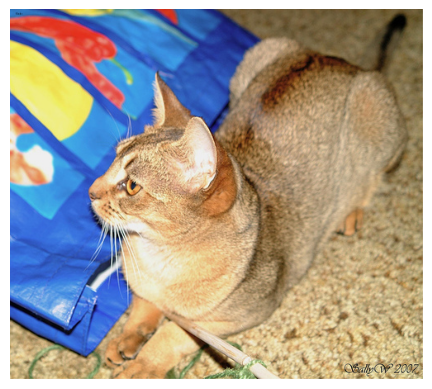

In [5]:
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array, array_to_img

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

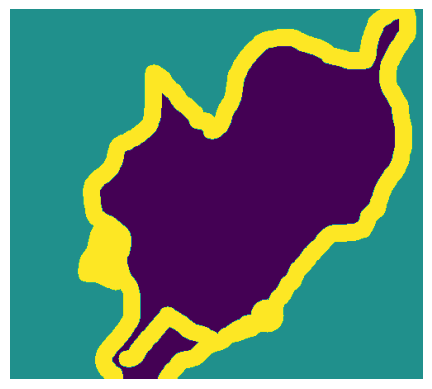

In [6]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [7]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale")
    )
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [0]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

#### Building and training the segmentation model

In [0]:
import keras
from keras.layers import Rescaling, Conv2D, Conv2DTranspose

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = Rescaling(1.0 / 255)(inputs)

    x = Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = Conv2D(128, 3, activation="relu", padding="same")(x)
    x = Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = Conv2D(256, 3, activation="relu", padding="same")(x)

    x = Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = Conv2DTranspose(256, 3, strides=2, activation="relu", padding="same")(x)
    x = Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)
    x = Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)

    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    return keras.Model(inputs, outputs)

model = get_model(img_size=img_size, num_classes=3)

In [0]:
# ⚠️NOTE⚠️: The following IoU metric is *very* slow on the PyTorch backend!
# If you are running with PyTorch, we recommend re-running the notebook with Jax
# or TensorFlow, or skipping to the next section of this chapter.

In [0]:
foreground_iou = keras.metrics.IoU(
    num_classes=3,
    target_class_ids=(0,),
    name="foreground_iou",
    sparse_y_true=True,
    sparse_y_pred=False,
)

In [0]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[foreground_iou],
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "oxford_segmentation.keras",
        save_best_only=True,
    ),
]
history = model.fit(
    train_input_imgs,
    train_targets,
    epochs=50,
    callbacks=callbacks,
    batch_size=64,
    validation_data=(val_input_imgs, val_targets),
)

In [0]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [0]:
model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

### Using a pretrained segmentation model

#### Downloading the Segment Anything Model

In [0]:
import keras_hub

model = keras_hub.models.ImageSegmenter.from_preset("sam_huge_sa1b")

In [0]:
model.count_params()

#### How Segment Anything works

#### Preparing a test image

In [0]:
path = keras.utils.get_file(
    origin="https://s3.amazonaws.com/keras.io/img/book/fruits.jpg"
)
pil_image = keras.utils.load_img(path)
image_array = keras.utils.img_to_array(pil_image)

plt.imshow(image_array.astype("uint8"))
plt.axis("off")
plt.show()

In [0]:
from keras import ops

image_size = (1024, 1024)

def resize_and_pad(x):
    return ops.image.resize(x, image_size, pad_to_aspect_ratio=True)

image = resize_and_pad(image_array)

In [0]:
import matplotlib.pyplot as plt
from keras import ops

def show_image(image, ax):
    ax.imshow(ops.convert_to_numpy(image).astype("uint8"))

def show_mask(mask, ax):
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w, _ = mask.shape
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(points, ax):
    x, y = points[:, 0], points[:, 1]
    ax.scatter(x, y, c="green", marker="*", s=375, ec="white", lw=1.25)

def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, ec="red", fc="none", lw=2))

#### Prompting the model with a target point

In [0]:
import numpy as np

input_point = np.array([[580, 450]])
input_label = np.array([1])

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_points(input_point, plt.gca())
plt.show()

In [0]:
outputs = model.predict(
    {
        "images": ops.expand_dims(image, axis=0),
        "points": ops.expand_dims(input_point, axis=0),
        "labels": ops.expand_dims(input_label, axis=0),
    }
)

In [0]:
outputs["masks"].shape

In [0]:
def get_mask(sam_outputs, index=0):
    mask = sam_outputs["masks"][0][index]
    mask = np.expand_dims(mask, axis=-1)
    mask = resize_and_pad(mask)
    return ops.convert_to_numpy(mask) > 0.0

mask = get_mask(outputs, index=0)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_points(input_point, plt.gca())
plt.show()

In [0]:
input_point = np.array([[300, 550]])
input_label = np.array([1])

outputs = model.predict(
    {
        "images": ops.expand_dims(image, axis=0),
        "points": ops.expand_dims(input_point, axis=0),
        "labels": ops.expand_dims(input_label, axis=0),
    }
)
mask = get_mask(outputs, index=0)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_points(input_point, plt.gca())
plt.show()

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(20, 60))
masks = outputs["masks"][0][1:]
for i, mask in enumerate(masks):
    show_image(image, axes[i])
    show_points(input_point, axes[i])
    mask = get_mask(outputs, index=i + 1)
    show_mask(mask, axes[i])
    axes[i].set_title(f"Mask {i + 1}", fontsize=16)
    axes[i].axis("off")
plt.show()

#### Prompting the model with a target box

In [0]:
input_box = np.array(
    [
        [520, 180],
        [770, 420],
    ]
)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_box(input_box, plt.gca())
plt.show()

In [0]:
outputs = model.predict(
    {
        "images": ops.expand_dims(image, axis=0),
        "boxes": ops.expand_dims(input_box, axis=(0, 1)),
    }
)
mask = get_mask(outputs, 0)
plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
plt.show()